In [35]:
pip install flask


   ------------------------------ --------- 3/4 [flask]
   ---------------------------------------- 4/4 [flask]

Note: you may need to restart the kernel to use updated packages.


## Importing the Modules

In [22]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Sk-learn for metrics and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

## Loading the Data and Preprocessing it

In [2]:
train_dir = 'DataSet/chest_xray/train'
test_dir  = 'DataSet/chest_xray/test'
valid_dir = 'DataSet/chest_xray/val'

Now labelling the pneumonia and normal one

In [3]:
def get_img(data_dir):
    data = []
    class_labels = ['NORMAL', 'PNEUMONIA'] 
    for label in class_labels:
        path = os.path.join(data_dir, label)
        class_num = class_labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.resize(img_arr, (150, 150)) 
                data.append((img_arr, class_num))
            except Exception as e:
                print(f"Error loading image: {img} - {e}")

    X = []
    y = []
    for img, label in data:
        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)


In [4]:
X_train, y_train = get_img(train_dir)
X_test, y_test = get_img(test_dir)
X_valid, y_valid = get_img(valid_dir)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of X_valid : {X_valid.shape}")

Shape of X_train : (5216, 150, 150)
Shape of X_test : (624, 150, 150)
Shape of X_valid : (16, 150, 150)


## Data Visualizing

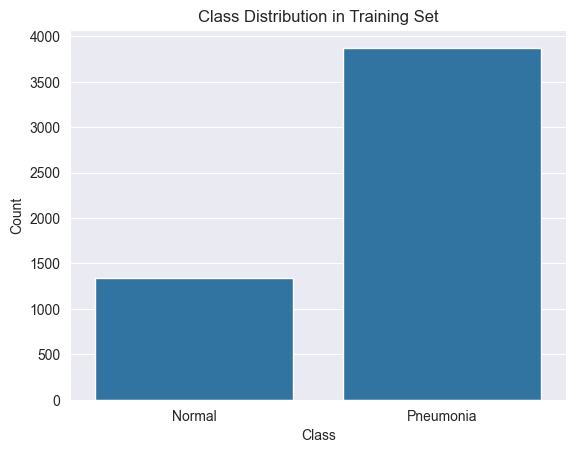

In [5]:
# Prepare label list
l = []
for img, label in zip(X_train, y_train):
    if label == 0:
        l.append("Normal")
    elif label == 1:
        l.append("Pneumonia")

# Plotting
sns.set_style('darkgrid')
sns.countplot(x=l)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.show()


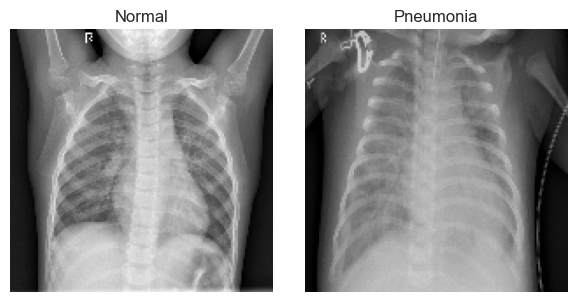

In [6]:
label_names = {0: 'NORMAL', 1: 'PNEUMONIA'}

samples = {}
for img, lbl in zip(X_train, y_train):
    if lbl not in samples:
        samples[lbl] = img
    if len(samples) == len(label_names):
        break

# Plotting
plt.figure(figsize=(9, 3))
for i, (lbl, img) in enumerate(samples.items()):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(label_names[lbl].capitalize())
    ax.axis('off')

plt.tight_layout()
plt.show()


Normalizing the Data

In [7]:
x_train = np.array(X_train) / 255
x_val = np.array(X_valid) / 255
x_test = np.array(X_test) / 255

In [8]:
img_size = 150
x_train = x_train.reshape(-1,img_size, img_size,1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_valid)

## Data Augumentation of the model

In [9]:
datagen = ImageDataGenerator(
           rotation_range = 30,
           zoom_range = 0.2,
           width_shift_range = 0.2,
           height_shift_range = 0.2,
           horizontal_flip = True,
           vertical_flip = False
)

datagen.fit(x_train)
train_gen = datagen.flow(x_train, y_train, batch_size=32)
val_gen = datagen.flow(x_val, y_val, batch_size=32)

## CNN Architecture

In [14]:
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# 2nd Convolutional Block
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# 3rd Convolutional Block
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# 4th Convolutional Block
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# 5th Convolutional Block
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

## Model Training

In [15]:
epochs = 30

lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

call_backs = [lr_reduction]

history = model.fit(
    train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = call_backs,
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 699ms/step - accuracy: 0.8089 - loss: 0.9829 - val_accuracy: 0.5000 - val_loss: 48.0098 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 724ms/step - accuracy: 0.8720 - loss: 0.3062 - val_accuracy: 0.5000 - val_loss: 59.5863 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8991 - loss: 0.2657
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 721ms/step - accuracy: 0.8991 - loss: 0.2656 - val_accuracy: 0.5000 - val_loss: 26.0917 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 710ms/step - accuracy: 0.9245 - loss: 0.2158 - val_accuracy: 0.5625 - val_loss: 2.6318 - learning_rate: 3.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 715ms/step - accuracy: 0.9381 - loss: 0.1648 - val_accuracy: 0.5000 - val_loss: 18.4392 - learning_rate: 3.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step -

## Evaluation


In [16]:
Loss, Accuracy = model.evaluate(x_test,y_test)
Accuracy = Accuracy * 100
print(f"Loss of the model is - {Loss}")
print(f"Accuracy of the model is - {Accuracy}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8908 - loss: 0.4473
Loss of the model is - 0.32320085167884827
Accuracy of the model is - 90.22436141967773%


## Plotting the Results

Text(0.5, 0, 'Epoch')

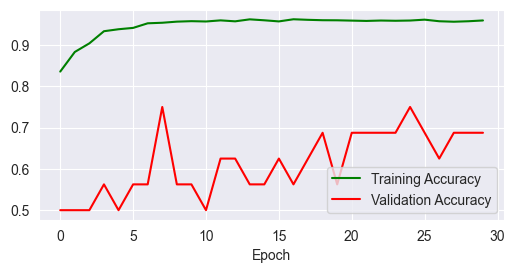

In [18]:
epochs = [i for i in range(30)]
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting
plt.figure(figsize = (6,6))
plt.subplot(2,1,1)
plt.plot(epochs,train_acc,'g', label = 'Training Accuracy')
plt.plot(epochs,val_acc,'r', label = 'Validation Accuracy')
plt.grid(True)
plt.legend()
plt.xlabel('Epoch')

## Predictions and report of classification

In [23]:
predictions = predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:50]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.43      0.93      0.59       234
   Normal (Class 1)       0.86      0.25      0.39       390

           accuracy                           0.51       624
          macro avg       0.64      0.59      0.49       624
       weighted avg       0.70      0.51      0.47       624



Confusion Matrix

<Axes: >

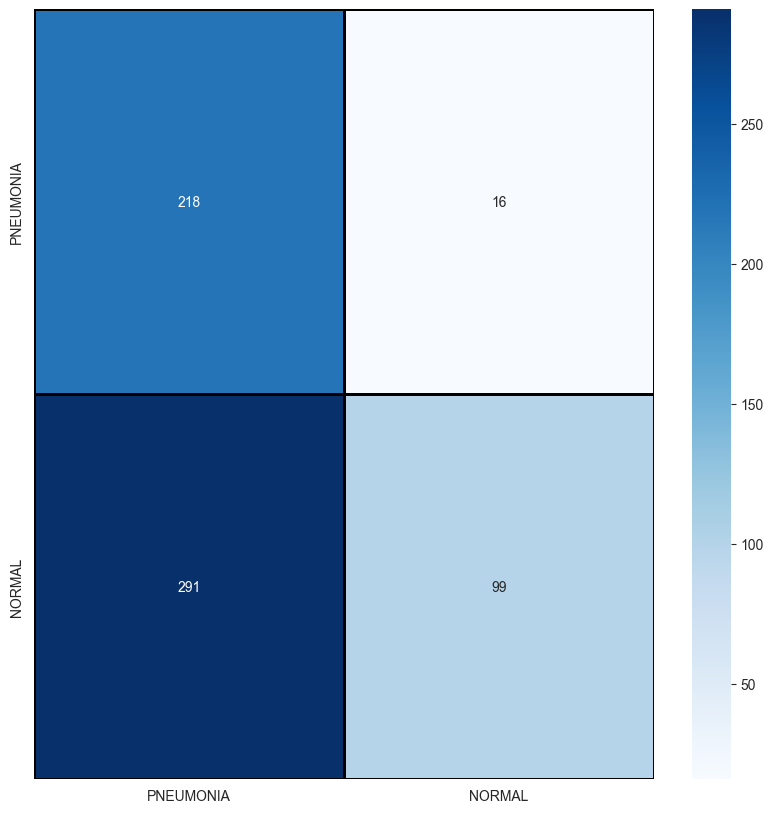

In [27]:
labels = ['PNEUMONIA', 'NORMAL']
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

The miss prediction is due to imbalance data and even the testing accuracy is more that means most of the data is in pneumonia class itself

In [33]:
# Saving the model
model.save("model.h5")